Oracle RF Fingerprinting

Paper available at :

 https://arxiv.org/pdf/1812.01124

 https://arxiv.org/pdf/1904.07623.pdf

 

Datasets from: 

https://mailuc-my.sharepoint.com/:f:/g/personal/wang2ba_ucmail_uc_edu/EjXyRTpV0Y5Dn-OjKlxKg8gBZWyq2PIHy5OPgh3bf3g4fg?e=B9oAJc

https://genesys-lab.org/oracle

In [ ]:
pip install sigmf

In [ ]:
!apt-get install axel
!axel -n 50 https://repository.library.northeastern.edu/downloads/neu:m044q523j?datastream_id=content #300mb data

In [ ]:
#run this if you need to download the 28gb dataset
!axel -n 100 https://repository.library.northeastern.edu/downloads/neu:m044q5210?datastream_id=content #28gb data

In [ ]:
!mv neu_m044q523j.zip iq_data_300mb.zip
!unzip iq_data_300mb.zip
!mv KRI-16IQImbalances-DemodulatedData KRI_16IQIMb_Demod

In [ ]:
import sigmf
import numpy as np
import pandas as pd
from sigmf import SigMFFile, sigmffile
import os
import glob,json
import re,pickle

import matplotlib.pyplot as plt

#importing the required libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout,Input
from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras import regularizers
from numpy.fft import fft, ifft,fftshift,ifftshift

from imblearn.over_sampling import SMOTE
from scipy.stats import wasserstein_distance #this is EMD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from scipy.signal import butter,filtfilt
from sklearn.model_selection import train_test_split
from scipy import signal

In [ ]:
#data preperation, run once to get rid of errors
files_data = glob.glob("./KRI_16IQIMb_Demod/*.sigmf-meta")
for f in files_data:
  file_handle = open(f,'r+')
  cur_json = json.load(file_handle)
  cur_json.update(cur_json['_metadata'])
  del cur_json['_metadata']
  file_handle.seek(0)
  iq_imbalance = re.search('%s(.*)%s' % ("_IQ#", "_run"), f).group(1)
  cur_json["annotations"][0]["genesys:transmitter"].update({"iq_balance":iq_imbalance})
  json.dump(cur_json,file_handle)
  file_handle.truncate()
  

In [ ]:
signal_handles = []
files_data = glob.glob("./KRI_16IQIMb_Demod/*.sigmf-meta")
for f in files_data:
  signal_handles.append(sigmffile.fromfile(f))
  

In [ ]:
#run as a test to see wether all data were loaded
df = pd.DataFrame({'real':[],'img':[],'blnc':[]})
stdscaler = StandardScaler()

for signal in signal_handles:
  sample_rate = signal.get_global_field(SigMFFile.SAMPLE_RATE_KEY)
  sample_count = signal.sample_count
  signal_duration = sample_count / sample_rate
  signal_sample = signal.read_samples().view(np.complex128).flatten()
  signal_balance = int(signal.get_annotations()[0]["genesys:transmitter"]["iq_balance"])
  df_tim = pd.DataFrame({'real':signal_sample.real,'img':signal_sample.imag,'blnc':np.repeat(signal_balance,len(signal_sample.real))})
  df = df.append(df_tim)

df.blnc.astype(int)
print(df.head())

       real       img  blnc
0 -1.244605  0.287226   5.0
1 -0.338152 -1.236006   5.0
2 -0.492135 -0.431267   5.0
3 -0.490911 -0.423873   5.0
4 -0.479247 -0.424971   5.0


In [ ]:
extra_data = []
handle_index = 0 
for signal in signal_handles:
  signal_sample = signal.read_samples().view(np.complex128).flatten()
  signal_balance = int(signal.get_annotations()[0]["genesys:transmitter"]["iq_balance"])

  for b in range(0,100):

    mu, sigma = 0, 0.01 +b/100
    noise = np.random.normal(mu, sigma, signal_sample.shape) 
    noise2 = np.random.normal(mu, sigma, signal_sample.shape)

    i_emd = wasserstein_distance(signal_sample.real,signal_sample.real + noise)
    q_emd = wasserstein_distance(signal_sample.imag,signal_sample.imag + noise2)
    if (i_emd + q_emd < 0.1):
      print("found sample at:",b)
      
      noisy_data = np.array((signal_sample.real + noise) + 1j*  (signal_sample.imag + noise2))
      extra_data.append({'data':noisy_data,'blnc':signal_balance,'sigma':sigma,'mu':mu})
    else:
      break

  break

In [ ]:
#show iq spectrum
for signal in signal_handles:
   signal_sample = signal.read_samples().view(np.complex128).flatten()
   signal_balance = signal.get_annotations()[0]["genesys:transmitter"]["iq_balance"]
   # Plot the spectogram of this data
   plt.scatter(np.real(signal_sample[0:100000]), np.imag(signal_sample[0:100000]))
   plt.title("Constellation of "+ signal_balance ) 
   plt.show() 


In [ ]:
# get the locations
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

sm = SMOTE(random_state = 42)

X_oversampled, y_oversampled = sm.fit_resample(X, y)
df_smote = pd.DataFrame(X_oversampled, columns=df.columns)
df_smote.blnc = y_oversampled

In [ ]:
#show how much data imbalance is there
equilibre = df.blnc.value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre,autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
equilibre

In [ ]:
unique_labels = sorted(df.iloc[:, -1].unique().astype('int16'))
train_ratio = 0.8
validate_ratio = 0.1
test_ratio = 0.1

x_train = np.zeros((1,2,128))
y_train = np.array([],dtype='int16')

x_test = np.zeros((1,2,128))
y_test = np.array([],dtype='int16')

x_val = np.zeros((1,2,128))
y_val = np.array([],dtype='int16')

for blnc,lbl in enumerate(unique_labels):
  data_blnc = df.loc[df["blnc"]==lbl]
  size_blnc = len(data_blnc)
  rem = size_blnc%128
  all_x_blnc = data_blnc.iloc[:,:-1].values[:size_blnc-rem].reshape((size_blnc//128,2,128))

  train_size = int(all_x_blnc.shape[0] * train_ratio)
  x_train = np.concatenate([x_train,all_x_blnc[0:train_size]])
  y_train = np.concatenate([y_train,np.repeat(blnc, train_size)])

  test_size = int(all_x_blnc.shape[0] * test_ratio)
  x_test = np.concatenate([x_test,all_x_blnc[train_size:train_size+test_size]])
  y_test = np.concatenate([y_test,np.repeat(blnc, test_size)])

  valid_size = int(all_x_blnc.shape[0] * validate_ratio)
  x_val = np.concatenate([x_val,all_x_blnc[train_size+test_size:train_size+test_size+valid_size]])
  y_val = np.concatenate([y_val,np.repeat(blnc, valid_size)])



In [ ]:
x_train = x_train[1:]
x_test = x_test[1:]
x_val = x_val[1:]

print(x_train.shape,x_test.shape,x_val.shape)
print(y_train.shape,y_test.shape,y_val.shape)
x_train,y_train

For static channels, we design a CNN architecture that uses
raw time-series IQ samples generated from 16-node USRP
X310 SDR testbed and the external database of 140 COTS
WiFi devices. Our proposed CNN architecture, as shown in
Fig. 4, is partly inspired from AlexNet [12]. It is a deep CNN
architecture specifically designed to classify 1.2 million highresolution images available in the ImageNet dataset into 1000
different classes. Unlike AlexNet, which is made up of 8 layers
(5 convolution and 3 fully connected), our CNN architecture
consists of four layers, with two convolution layers and two
fully connected (or dense) layers. The input to our CNN is a
windowed sequence of raw IQ samples with length 128. We
choose a sliding window approach to partition the training
samples that enhances the shift invariance of the features
learned by the CNN. Each complex value is represented as
two-dimensional real values (i.e., I and Q are two real value
streams), which results in the dimension of our input data
growing to 2 × 128. This is then fed to the first convolution
layer. The convolution layer consists of a set of spatial filters,
also called kernels, that perform a convolution operation over
Figure 5: Box plot for the classification of WiFi devices using CNN.
input data to extract the features. The first convolution layer
consists of 50 filters, each of size 1 × 7, in which each
filter learns a 7-sample variation in time over the I or Q
dimension separately, to generate 50 distinct feature maps over
the complete input sample. Similarly, the second convolution
layer has 50 filters each of size 2 × 7 and each filter learns
variations, again of 7 activation values, over both I and Q
dimensions of the 50-dimensional activation volume obtained
after the first convolution layer. Each convolution layer is
followed by a Rectified Linear Unit (ReLU) activation, that
performs a pre-determined non-linear transformation on each
element of the convolved output.
The output of the second convolution layer is then provided
as input to the first fully connected layer, which has 256
neurons. A second fully connected layer of 80 neurons is
added to extract higher level non-linear combinations of the
features extracted from previous layers, which are finally
passed to a classifier layer. A softmax classifier is used in
the last layer to output the probabilities of each sample being
fed to the CNN. The choice of hyperparameters such as filter
size, number of filters in the convolution layers and the depth
of the CNN is of high importance to ensure that our CNN
model generalizes well. These are chosen carefully through
cross validation. In order to overcome overfitting, we set the
dropout rate to 50% at the dense layers. We also use an
`2 regularization parameter λ = 0.0001. The weights of the
network are trained using Adam optimizer with a learning rate
of lr = 0.0001. We minimize the prediction error through
back-propagation, using categorical cross-entropy as a loss
function computed on the classifier output. We implement our
CNN architecture in Keras running on top of TensorFlow on
a system with 8 NVIDIA Cuda enabled Tesla K80m GPU

In [ ]:
#defining model
model=Sequential()
#adding convolution layer
model.add(Conv2D(50,(1,7),activation='relu',input_shape=(2,128,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2),strides=1,padding="same"))

model.add(Conv2D(50,(2,7),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2),strides=1,padding="same"))

model.add(Flatten())

model.add(Dense(256,kernel_regularizer=regularizers.L2(l2=1e-4) ))
model.add(Dropout(0.5))
model.add(Dense(80,kernel_regularizer=regularizers.L2(l2=1e-4) ))
model.add(Dropout(0.5))

#adding output layer
model.add(Dense(16,activation='softmax' ))
#compiling the model
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'])


In [ ]:
#fitting the model
model.fit(x_train,y_train,epochs=5,validation_data=(x_test, y_test),)

In [ ]:
def convertiq_stream(iq_stream):
  data_blnc = pd.DataFrame({'real':iq_stream.real,'img':iq_stream.imag})
  size_blnc = len(data_blnc)
  rem = size_blnc%128
  return data_blnc.values[:size_blnc-rem].reshape((size_blnc//128,2,128))


In [ ]:
signal = extra_data[7]
test_val = convertiq_stream(signal['data'][:1000]) #convertiq_stream(extra_data[0]['data'])
signal_balance = signal['blnc']
print('balance:',signal_balance)
out = model.predict(test_val[:1000])

prob_ary = np.array([])

for i in range(0,len(out)):
      j = np.argmax(out[i])
      pred_label = unique_labels[j]
      print(sorted(unique_labels)[j])
      #prob_ary = np.append(prob_ary,pred_label)
      

In [ ]:
!axel -n 20 https://f002.backblazeb2.com/file/deepsig-datasets/2016.10/RML2016.10b.tar.bz2?Authorization=3_20221219203105_883afad16640e8c098de17c6_81a1534b9be93d82c7ac16cfc26b2e2c2259f4e2_002_20221219213105_0027_dnld
!tar xvf RML2016.10b.tar.bz2.0

In [ ]:
file_class = open("RML2016.10b.dat",'rb')
Xd = pickle.load(file_class, encoding = 'bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = [] 
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file_class.close()

In [ ]:
features = {}
features['raw']        = X[:,0], X[:,1]

In [ ]:
def xcorr(x):
  """FFT based autocorrelation function, which is faster than numpy.correlate"""
  # x is supposed to be an array of sequences, of shape (totalelements, length)
  fftx = fft(x)
  ret = ifft(fftx * np.conjugate(fftx))
  ret = fftshift(ret)
  return ret

In [ ]:
def autocorr(x):
   result = np.correlate(x, x, mode='full')
   return result[int(result.size/2):]

In [ ]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [ ]:
def generateTone(fs, toneFreq, numSamples, amplitude):
    #Generates a sinusoidal signal with the specified
    #frequency and amplitude
    
    step = (float(toneFreq) / float(fs)) * 2.0 * np.pi
    phaseArray = np.array(range(0,numSamples)) * step
    
    #Euler's Formular: e^(j*theta) = cos(theta) + j * sin(theta)
    #For a complex sinusoidal theta = 2*pi*f*t where each time step is 1/fs    
    wave = np.exp(1.0j * phaseArray) * amplitude
    return wave

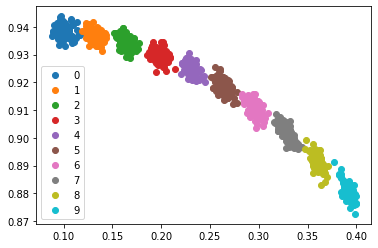

In [ ]:
no_sig = 10**6
base_band = generateTone(10**3,10**3,no_sig,1)
base_power = (base_band * np.conj(base_band)).real

for i in range(0,10):
  target_snr_db = 10
  # Calculate signal power and convert to dB 
  sig_avg_watts = np.mean(base_power)
  sig_avg_db = 10 * np.log10(sig_avg_watts)
  # Calculate noise according to [2] then convert to watts
  noise_avg_db = sig_avg_db - target_snr_db
  noise_avg_watts = 10 ** (noise_avg_db / 10)
  # Generate an sample of white noise
  mean_noise = 0
  noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(base_power)) + 1j * np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(base_power))


  var_theta = np.radians(3 + i)
  var_epsilon = 0.1 + i/100

  var_alpha = np.cos(var_theta) + 1j * var_epsilon * np.sin(var_theta)
  var_beta = var_epsilon * np.cos(var_theta) + 1j * np.sin(var_theta)
  r_sig = var_alpha * base_band + var_beta * np.conj(base_band) + noise_volts
  Y_mat = np.array([r_sig,np.conj(r_sig)])

  vctr1 = r_sig * r_sig
  vctr2  = r_sig * np.conj(r_sig)
  
  vctr_size = len(vctr1)
  batch_size = int(no_sig/100)
  leftover = vctr_size % batch_size
  finger_array = np.array([])
  for s_x in range(0,vctr_size-batch_size,batch_size):
    vctr3 = np.mean((vctr1[s_x:s_x+batch_size]))/np.mean((vctr2[s_x:s_x+batch_size]))
    finger_print = (1 + 1/10**( target_snr_db/10))*vctr3
    finger_array = np.append(finger_array,finger_print)
  
  plt.scatter(finger_array.imag, finger_array.real,label=i)

plt.legend()
plt.show()

In [ ]:
snr_new = 20

for label in unique_labels:
  data_blnc = df.loc[df["blnc"]==label]
  r_sig = (data_blnc['real'] + 1j * data_blnc['img'] ).to_numpy()
  Y_mat = np.array([r_sig,np.conj(r_sig)])

  vctr1 = r_sig * r_sig
  vctr2  = r_sig * np.conj(r_sig)
  
  vctr_size = len(vctr1)
  batch_size = int(vctr_size/10)
  finger_array = np.array([])

  for s_x in range(0,vctr_size-batch_size,batch_size):
    vctr3 = np.mean(xcorr(vctr1[s_x:s_x+batch_size]))/np.mean(xcorr(vctr2[s_x:s_x+batch_size]))
    finger_print = (1 + 1/10**( snr_new/10))*vctr3
    finger_array = np.append(finger_array,finger_print)
  
  plt.scatter(finger_array.imag, finger_array.real,label=label)

plt.legend()
plt.show()

In [ ]:
def inp_func(iq_in):
  iq_val = np.array([[iq_in],[np.conj(iq_in)]])
  print(iq_val)

In [ ]:
iq_sample = complex(1 ,-0.5)
iq_ary1 = np.array([[iq_sample],[np.conj(iq_sample)]])
iq_ary2 = np.conj(iq_ary1.T)
xcorr(iq_ary1*iq_ary2)

array([[1.875+0.j, 3.125+0.j],
       [1.875+0.j, 3.125+0.j]])

In [ ]:
def normalize_complex_arr(a):
    a_oo = a - a.real.min() - 1j*a.imag.min() # origin offsetted
    return a_oo/np.abs(a_oo).max()

In [ ]:

for label in unique_labels:
  data_blnc = df.loc[df["blnc"]==label]
  r_sig = (data_blnc['real'] + 1j * data_blnc['img'] ).to_numpy()[:2000]
  scaled_sig = normalize_complex_arr(r_sig)

  freqs, psd = signal.welch(scaled_sig,fs=5*(10**6),return_onesided=False)

  fig, ax = plt.subplots()
  ax.semilogx(freqs, psd)
  plt.title('PSD: power spectral density')
  plt.xlabel('Frequency')
  plt.ylabel('Power')

plt.show()

In [ ]:
#show Power spectral density
for signal in signal_handles:
   signal_sample = signal.read_samples().view(np.complex128).flatten()
   signal_balance = signal.get_annotations()[0]["genesys:transmitter"]["iq_balance"]
   # Plot the spectogram of this data
   plt.psd(signal_sample, NFFT=1024, Fs=1000000)
   plt.title("PSD of "+signal_balance ) 
   plt.show() 
